In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/exp8/human_segmentation/models'
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


-----------

# 1. 인물사진 모드 사용

In [4]:
img_path = os.getenv('HOME')+'/aiffel/exp8/human_segmentation/images/image.png'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1920, 1920, 3)


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1920, 1920, 3) (513, 513, 3) 15


## 인물 라벨인 15와 배경 라벨인 0을 사용하여 세그맨테이션을 진행합니다.

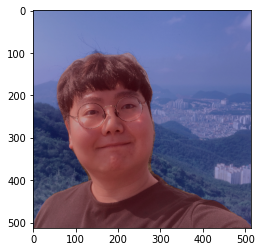

In [6]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 만들어진 세그멘테이션으로 마스크를 생성합니다.

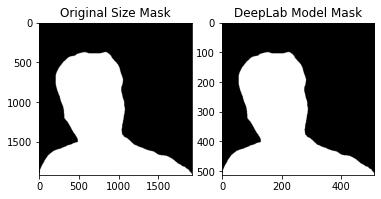

In [7]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 30 정도로 배경흐림을 진행합니다.

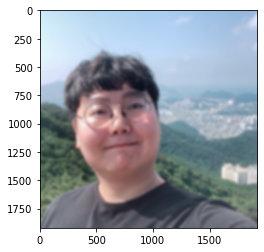

In [8]:
img_orig_blur = cv2.blur(img_orig, (30,30))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 배경흐림이 진행된 배경에서 마스크 영역을 삭제해줍니다.

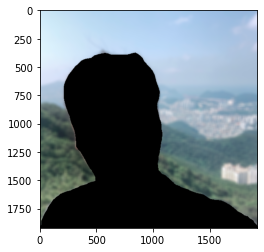

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 마스크 영역이 삭제된 배경을 원본 사진에 합성해줍니다.

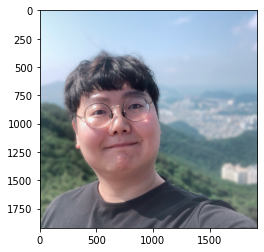

In [10]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---------

# 2. 세그멘테이션을 활용한 배경합성

## 배경합성을 진행할 배경을 가져옵니다.

In [11]:
background_path = os.getenv('HOME')+'/aiffel/exp8/human_segmentation/images/background.jpg'
background_orig = cv2.imread(background_path) 
print (background_orig.shape)

(4885, 4885, 3)


## 합성의 편의를 위해 합성할 배경을 인물사진 크기로 리사이즈합니다.

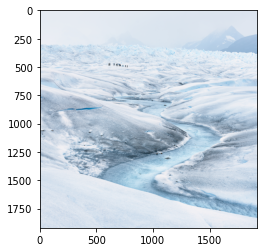

In [12]:
background_show = background_orig.copy()
background_resized = cv2.resize(background_show, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(background_resized, cv2.COLOR_BGR2RGB))
plt.show()

## 합성할 배경에 배경흐림을 적용합니다.

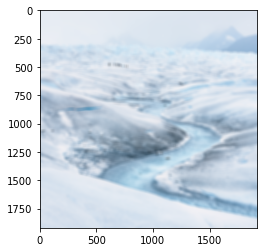

In [13]:
background_blur = cv2.blur(background_resized, (30,30))
plt.imshow(cv2.cvtColor(background_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 위에 기존에 생성한 마스크 영역을 삭제해줍니다.

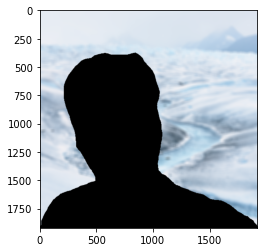

In [14]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(background_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 마스크영역이 삭제된 배경과 기존의 인물 사진을 합성해줍니다.

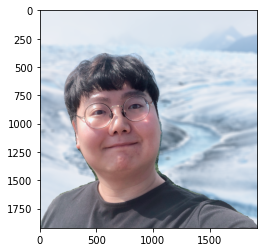

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---------

# 다른 사진에 대해서도 인물사진 모드를 적용해 보았습니다.

In [16]:
img2_path = os.getenv('HOME')+'/aiffel/exp8/human_segmentation/images/image2.jpeg'
img2_orig = cv2.imread(img2_path) 
print (img2_orig.shape)

(2663, 2663, 3)


In [17]:
img2_resized, seg_map = MODEL.run(img2_orig)
print (img2_orig.shape, img2_resized.shape, seg_map.max())

(2663, 2663, 3) (513, 513, 3) 15


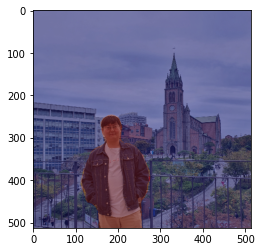

In [18]:
img2_show = img2_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img2_show = cv2.addWeighted(img2_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB))
plt.show()

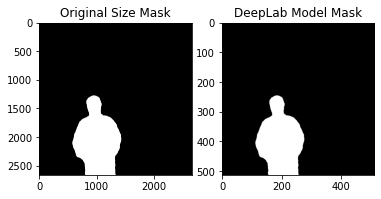

In [19]:
img_mask_up = cv2.resize(img_mask, img2_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

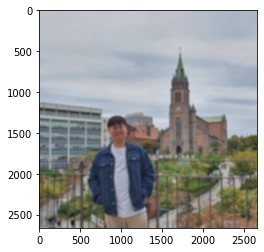

In [20]:
img2_orig_blur = cv2.blur(img2_orig, (30,30))
plt.imshow(cv2.cvtColor(img2_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

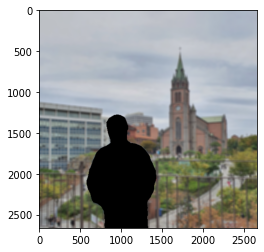

In [21]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img2_bg_blur = cv2.bitwise_and(img2_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img2_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

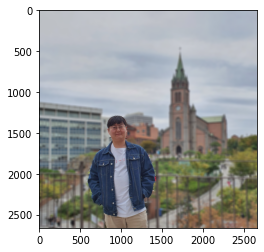

In [22]:
img2_concat = np.where(img_mask_color==255, img2_orig, img2_bg_blur)
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 정상적으로 인물사진 모드가 적용되고 있습니다.

------------

# 3. 고양이 사진 인물사진모드 적용

## 고양이 사진을 불러옵니다. 저희 집 금별이 많이 사랑해주세요.

In [23]:
img_path = os.getenv('HOME')+'/aiffel/exp8/human_segmentation/images/cat.jpeg'
cat_orig = cv2.imread(img_path) 
print (cat_orig.shape)

(3024, 3024, 3)


In [24]:
cat_resized, seg_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, seg_map.max())

(3024, 3024, 3) (513, 513, 3) 8


## 고양이 라벨인 8과 배경 라벨인 0을 통해 세그멘테이션을 진행해줍니다.
## 고양이가 앉아있는 스크레쳐의 일부분이 고양이로 인식되고 있습니다.

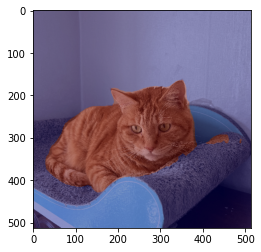

In [25]:
cat_show = cat_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

## 만들어진 세그멘테이션으로 마스크를 생성합니다.

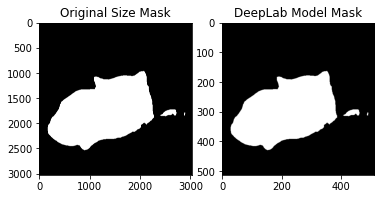

In [26]:
img_mask_up = cv2.resize(img_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 배경이 밋밋하여 변화를 더 잘 볼 수 있도록 배경흐림 효과를 좀 더 강하게 주었습니다.

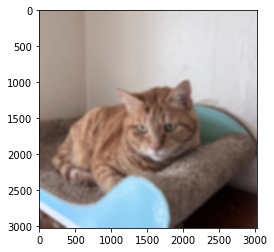

In [27]:
cat_orig_blur = cv2.blur(cat_orig, (50,50))
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 배경흐림이 진행된 사진에 마스크를 활용하여 마스크 영역을 삭제해줍니다.

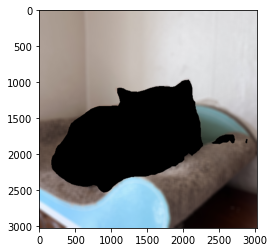

In [28]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(cat_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 마스크 영역이 삭제된 배경과 기존의 사진을 합성해줍니다.

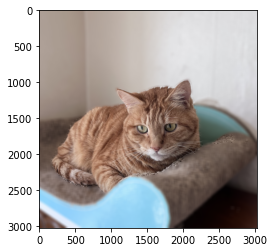

In [29]:
cat_concat = np.where(img_mask_color==255, cat_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 마스크가 약간 잘 못 그려졌지만 다행히 어색하지 않은 결과물이 만들어졌습니다.

-------------

# 4. 잘 못 그려진 마스크 확인 및 인물사진 모드의 문제점

In [30]:
cat_mask_path = os.getenv('HOME')+'/aiffel/exp8/human_segmentation/images/cat_mask.png'
cv2.imwrite(cat_mask_path, img_bg_blur)

True

In [31]:
from IPython.display import Image

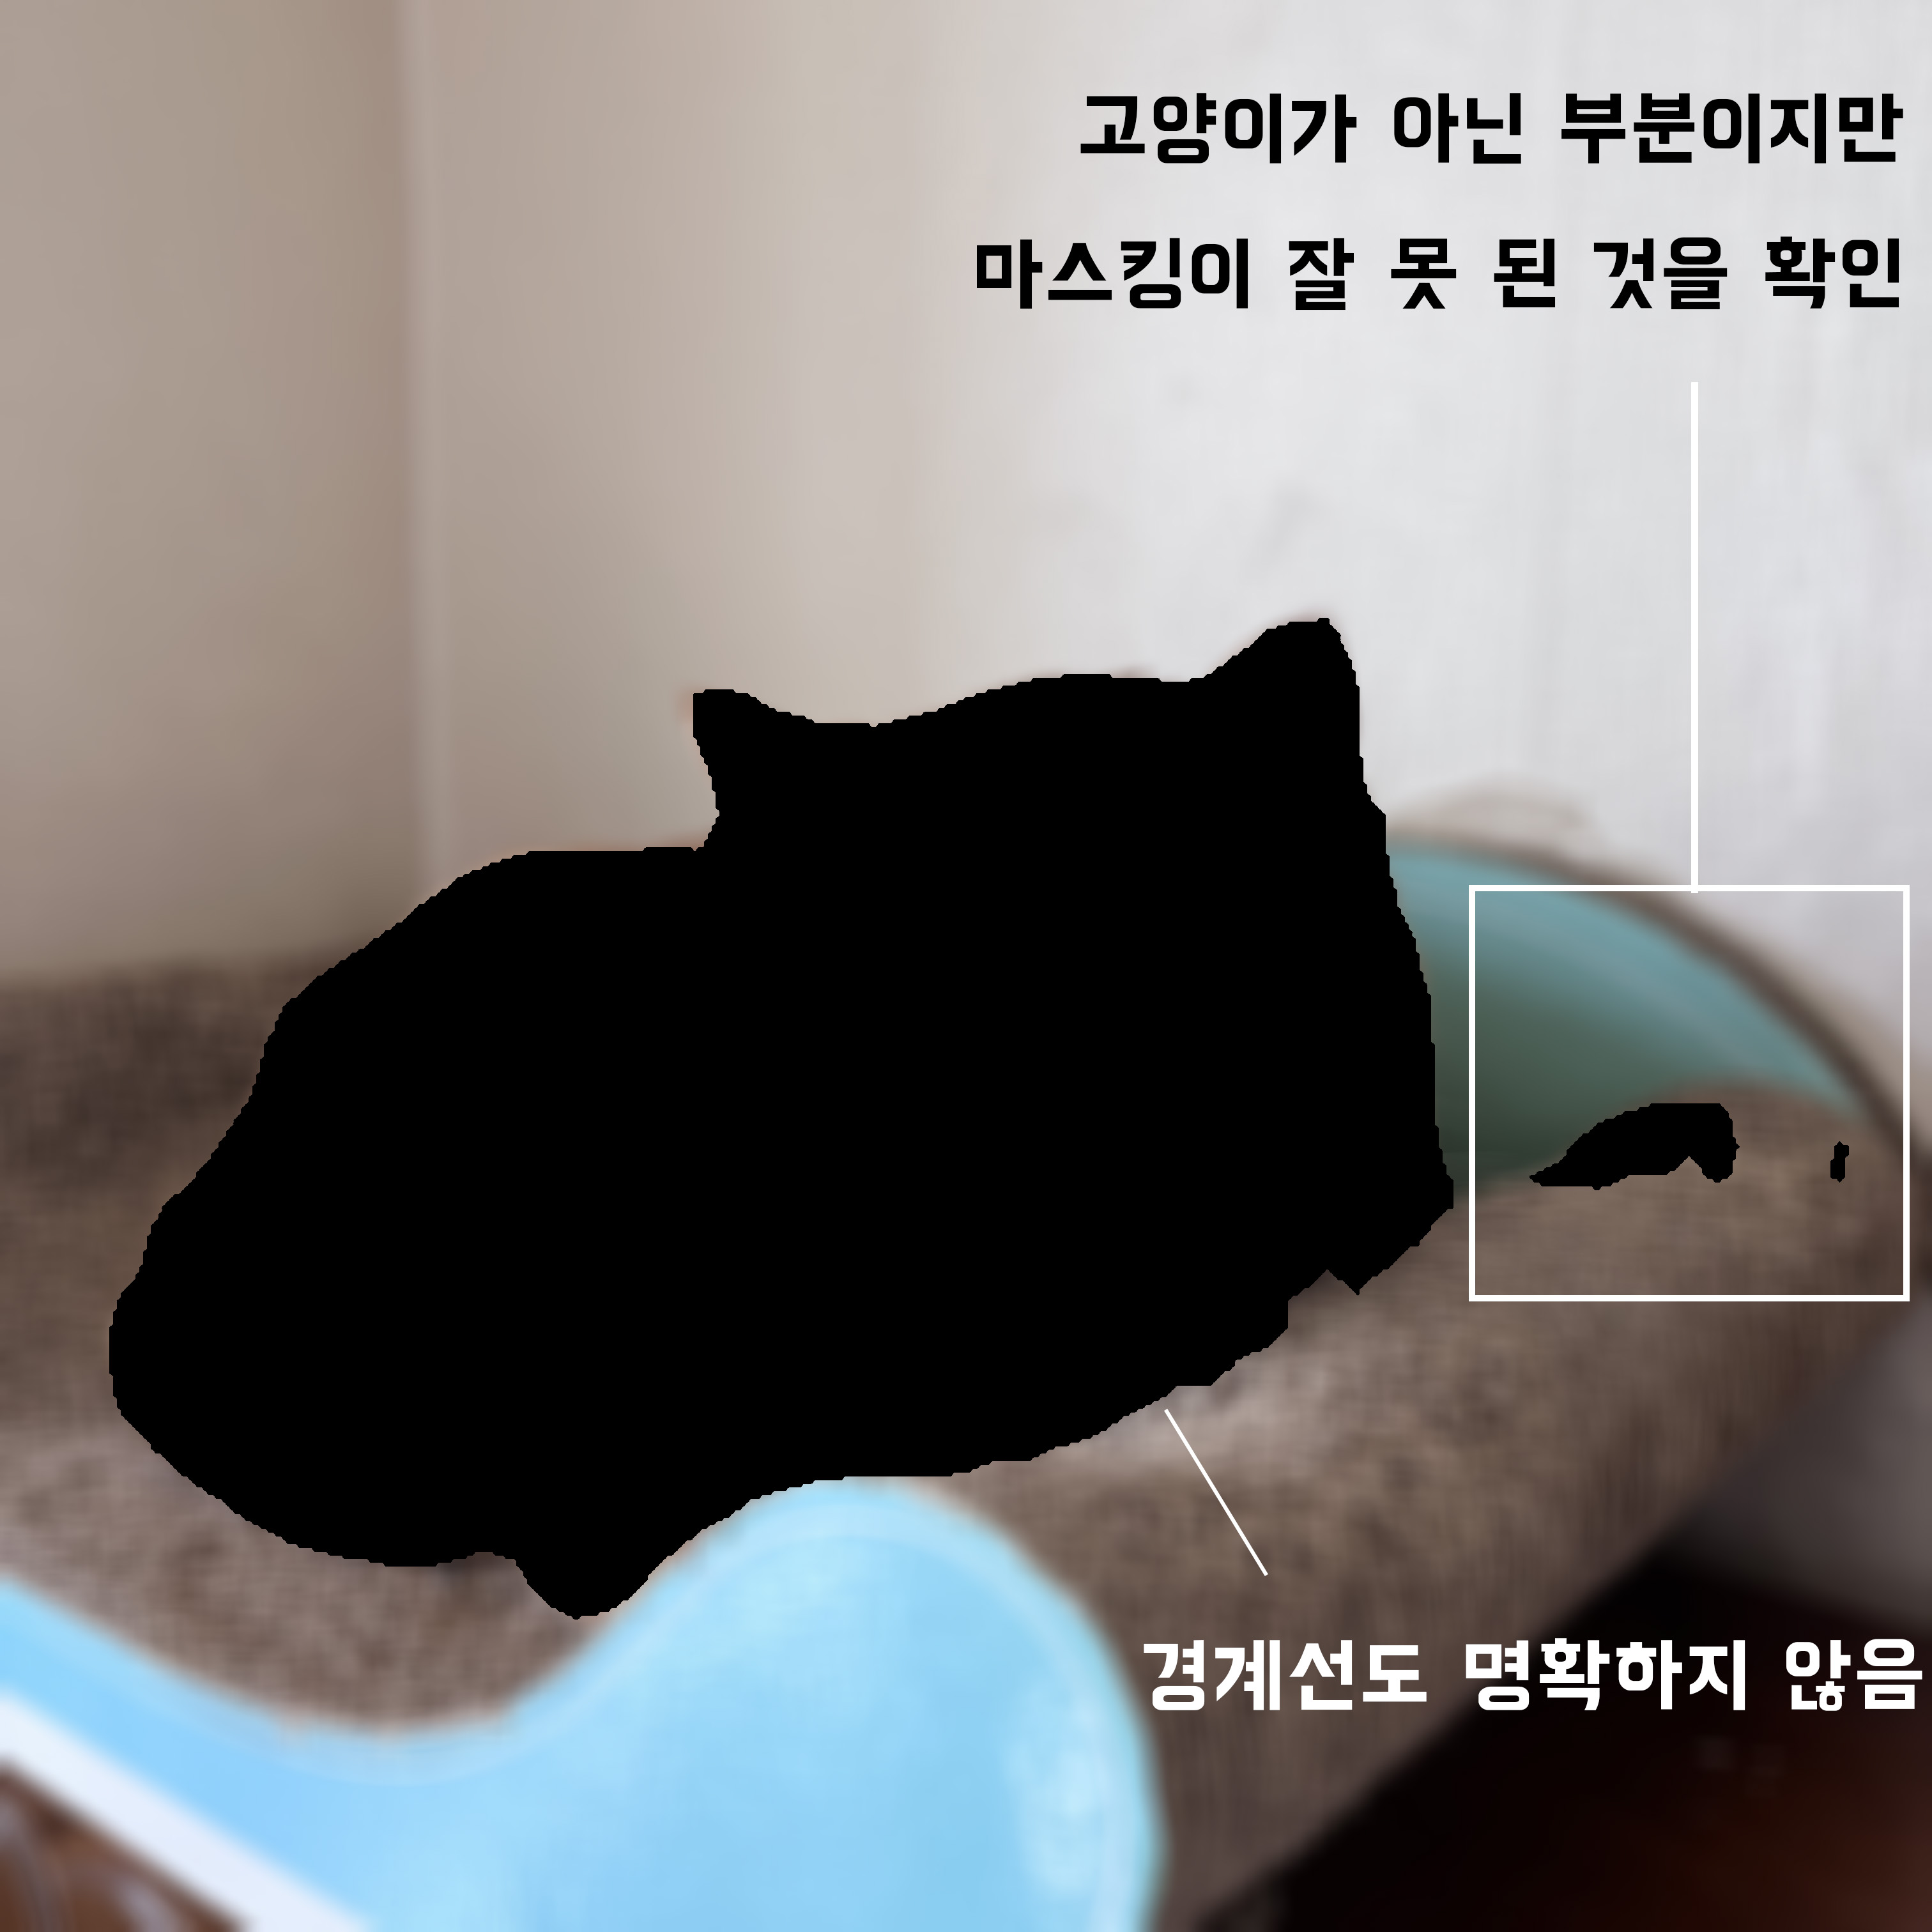

In [32]:
Image('/aiffel/aiffel/exp8/human_segmentation/images/wrong_mask.jpg')

# 5. 인물사진 모드에서 발생한 문제점에 대한 솔루션 제시

## 첫 번째로 생각할 수 있는 방안은 세그멘테이션에 더해 듀얼카메라나 ToF를 활용한 3D Depth 인식을 활용하는 방식입니다.
## 세그멘테이션으로 대략적으로 피사체를 분리한 후에 피사체 전후로 피사계 심도에 따른 배경흐림을 취해줍니다.
## 이러한 방식을 활용하게 되면 위의 사진처럼 세그멘테이션의 경계선이 명확하지 않은 경우에도 피사계 심도에 따른 배경흐림을 통해 자연스러운 인물사진 모드를 구현할 수 있을 것입니다.

## 두 번째는 DeepLabModel 개선입니다.
## 인물 사진에서는 상대적으로 경계선이 명확했으나 고양이 사진의 경우 스크래쳐와 고양이 사이의 경계선이 명확하지 않거나 고양이가 아닌 부분을 고양이로 인식하는 모습을 볼 수 있었습니다.
## 이는 스크레쳐의 색과 패턴이 고양이 털 부분과 비슷하게 인식 될 여지가 있기 때문인 것으로 보여집니다.
## 인물사진 모드에서 고양이 같은 경계선이 어려운 피사체 분리가 좀 더 정확히 이루어지기 위해서는 고양이의 털 단위까지도 명확하게 인식할 수 있도록 DeepLabModel을 개선해야할 것입니다.